<a href="https://colab.research.google.com/drive/1GqAhNZ6_Fm3PN_wX69MiBe7Pc6g2PjtK#scrollTo=cf2bee4f-c0b2-49e1-8a9c-3688c2d5fb55" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Improve retrieval quality of your LLM Application with AIMon and Milvus

## Overview

In this tutorial, we'll help you build a retrieval-augmented generation (RAG) chatbot that answers questions on a [meeting bank dataset](https://meetingbank.github.io/).

In this tutorial you will learn to:

*   Build an LLM application that answers a user's query related to the meeting bank dataset.
*   Define and measure the quality of your LLM application.
*   Improve the quality of your application using 2 incremental approaches: a vector DB using hybrid search and a state-of-the-art re-ranker.


## Tech Stack

#### *Vector Database*

For this application, we will use [Milvus](https://milvus.io/) to manage and search large-scale unstructured data, such as text, images, and videos.

#### *LLM Framework*
LlamaIndex is an open-source data orchestration framework that simplifies building large language model (LLM) applications by facilitating the integration of private data with LLMs, enabling context-augmented generative AI applications through a Retrieval-Augmented Generation (RAG) pipeline. We will use LlamaIndex for this tutorial since it offers a good amount of flexibility and better lower level API abstractions.

#### *LLM Output Quality Evaluation*
[AIMon](https://www.aimon.ai) offers proprietary Judge models for Hallucination, Context Quality issues, Instruction Adherence of LLMs, Retrieval Quality and other LLM reliability tasks. We will use AIMon to judge the quality of the LLM application.


In [2]:
!pip3 install -U gdown requests aimon llama-index-core llama-index-vector-stores-milvus pymilvus>=2.4.2 llama-index-postprocessor-aimon-rerank llama-index-embeddings-openai llama-index-llms-openai datasets fuzzywuzzy --quiet

# Pre-requisites

1. Signup for an [AIMon account here](https://docs.aimon.ai/quickstart).

  Add this secret to the Colab Secrets (the "key" symbol on the left panel)
  > If you are in another non-google colab environment, please replace the google colab-related code yourself


  * AIMON_API_KEY

2. Signup for an [OpenAI account here](https://platform.openai.com/docs/overview) and add the following key in Colab secrets:
  * OPENAI_API_KEY


### Required API keys

In [ ]:
import os

# Check if the secrets are accessible
from google.colab import userdata

# Get this from the AIMon UI
aimon_key = userdata.get("AIMON_API_KEY")

openai_key = userdata.get("OPENAI_API_KEY")

# Set OpenAI key as an environment variable as well
os.environ["OPENAI_API_KEY"] = openai_key

## Utility Functions

This section contains utility functions that we will use throughout the notebook.

In [ ]:
from openai import OpenAI

oai_client = OpenAI(api_key=openai_key)


def query_openai_with_context(query, context_documents, model="gpt-4o-mini"):
    """
    Sends a query along with context documents to the OpenAI API and returns the parsed response.

    :param api_key: OpenAI API key
    :param query: The user's query as a string
    :param context_documents: A list of strings representing context documents
    :param model: The OpenAI model to use (default is 'o3-mini')
    :return: Response text from the OpenAI API
    """

    # Combine context documents into a single string
    context_text = "\n\n".join(context_documents)

    # Construct the messages payload
    messages = [
        {
            "role": "system",
            "content": "You are an AI assistant that provides accurate and helpful answers.",
        },
        {"role": "user", "content": f"Context:\n{context_text}\n\nQuestion:\n{query}"},
    ]

    # Call OpenAI API
    completion = oai_client.chat.completions.create(model=model, messages=messages)

    # Extract and return the response text
    return completion.choices[0].message.content

# Dataset

We will use the [MeetingBank](https://meetingbank.github.io/) dataset which is a benchmark dataset created from the city councils of 6 major U.S. cities to supplement existing datasets. It contains 1,366 meetings with over 3,579 hours of video, as well as transcripts, PDF documents of meeting minutes, agenda, and other metadata.

For this exercise, we have created a smaller dataset. It can be found [here](https://drive.google.com/drive/folders/1v3vJahKtadi_r-8VJAsDd2eaiSRenmsa?usp=drive_link).

In [ ]:
# Delete the dataset folder if it already exists

import shutil

folder_path = "/content/meetingbank_train_split.hf"

if os.path.exists(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except Exception as e:
        print(f"Error deleting folder '{folder_path}': {e}")
else:
    print(f"Folder '{folder_path}' does not exist.")

Folder '/content/meetingbank_train_split.hf' does not exist.


In [ ]:
# Download the dataset locally
!gdown https://drive.google.com/uc?id=1bs4kwwiD30DUeCjuqEdOeixCuI-3i9F5
!gdown https://drive.google.com/uc?id=1fkxaS8eltjfkzws5BRXpVXnxl2Qxwy5F

Downloading...
From: https://drive.google.com/uc?id=1bs4kwwiD30DUeCjuqEdOeixCuI-3i9F5
To: /content/meetingbank_train_split.tar.gz
100% 1.87M/1.87M [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fkxaS8eltjfkzws5BRXpVXnxl2Qxwy5F
To: /content/score_metrics_relevant_examples_2.csv
100% 163k/163k [00:00<00:00, 69.6MB/s]


In [ ]:
import tarfile
from datasets import load_from_disk


tar_file_path = "/content/meetingbank_train_split.tar.gz"
extract_path = "/content/"

# Extract the file
with tarfile.open(tar_file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print(f"Extracted to: {extract_path}")

train_split = load_from_disk(extract_path + "meetingbank_train_split.hf")

Extracted to: /content/


In [ ]:
len(train_split)

258

In [ ]:
# Total number of token across the entire set of transcripts
# This is approximately 15M tokens in size
total_tokens = sum(len(example["transcript"].split()) for example in train_split)
print(f"Total number of tokens in train split: {total_tokens}")

Total number of tokens in train split: 996944


In [ ]:
# number of words ~= # of tokens
len(train_split[1]["transcript"].split())

3137

In [ ]:
# Show the first 500 characters of the transcript
train_split[1]["transcript"][:500]

"An assessment has called out council bill 161 for an amendment. Madam Secretary, will you please put 161 on the screen? Councilman Lopez, will you make a motion to take 161 out of order? Want to remind everyone this motion is not debatable. Thank you, Mr. President. I move to take Council Bill 161 series of 2017. Out of order. All right. It's been moved the second it. Madam Secretary, roll call. SUSSMAN All right, Black. CLARK All right. Espinosa. Flynn. Gilmore. Herndon. Cashman can eat. LOPEZ "

In [ ]:
# Average number of tokens per transcript
import statistics

statistics.mean(len(example["transcript"].split()) for example in train_split)

3864.124031007752

### Analysis

We have 258 transcripts with a total of about 1M tokens across all these transcripts. We have an average of 3864 number of tokens per transcript.

| Metric | Value |
|------------------|------------------|
| Number of transcripts | 258 |
| Total # tokens in the transcripts | 1M |
| Avg. # tokens per transcript | 3864 |


### Queries

Below are the 12 queries that we will run on the transcript above

In [ ]:
import pandas as pd

queries_df = pd.read_csv("/content/score_metrics_relevant_examples_2.csv")

In [ ]:
len(queries_df["Query"])

12

In [ ]:
queries_df["Query"].to_list()

['What was the key decision in the meeting?',
 'What are the next steps for the team?',
 'Summarize the meeting in 10 words.',
 'What were the main points of discussion?',
 'What decision was made regarding the project?',
 'What were the outcomes of the meeting?',
 'What was discussed in the meeting?',
 'What examples were discussed for project inspiration?',
 'What considerations were made for the project timeline?',
 'Who is responsible for completing the tasks?',
 'What were the decisions made in the meeting?',
 'What did the team decide about the project timeline?']

# Metric Definition

This quality score metric will help us understand how good the LLM responses are for the set of queries above. To measure quality of our application, we will run a set of queries and aggregate the quality scores across all these queries.

LLM Application Quality Score is a combination of 3 individual quality metrics from AIMon:

1. **Hallucination Score** (hall_score): checks if the generated text is grounded in the provided context. A score closer to 1.0 means that there is a strong indication of hallucination and a score closer to 0.0 means a lower indication of hallucination. Hence, we will use (1.0-hall_score) here when computing the final quality score.
2. **Instruction Adherence Score** (ia_score): checks if all explicit instructions provided have been followed by the LLM. The higher the ia_score the better the adherence to instructions. The lower the score, the poorer the adherence to instructions.
3. **Retrieval Relevance Score** (rr_score): checks if the retrieved documents are relevant to the query. A score closer to 100.0 means perfect relevance of document to query and a score closer to 0.0 means poor relevance of document to query.

`quality_score = 0.35 * (1.0 - hall_score) + 0.35 * ia_score + 0.3 * rr_score`

In [ ]:
# We will check the LLM response against these instructions
instructions_to_evaluate = """
1. Ensure that the response answers all parts of the query completely.
2. Ensure that the length of the response is under 50 words.
3. The response must not contain any abusive language or toxic content.
4. The response must be in a friendly tone.
"""

In [ ]:
def compute_quality_score(aimon_response):
    retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0][
        "relevance_scores"
    ]
    avg_retrieval_relevance_score = (
        statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
    )
    hall_score = aimon_response.detect_response.hallucination["score"]
    ia_score = aimon_response.detect_response.instruction_adherence["score"]
    return (
        0.35 * (1.0 - hall_score)
        + 0.35 * ia_score
        + 0.3 * (avg_retrieval_relevance_score / 100)
    ) * 100.0

# Setup AIMon

As mentioned previously, AIMon will be used to judge the quality of the LLM application. [Documentation can be found here](https://docs.aimon.ai/).

In [ ]:
from aimon import Detect

aimon_config = {
    "hallucination": {"detector_name": "default"},
    "instruction_adherence": {"detector_name": "default"},
    "retrieval_relevance": {"detector_name": "default"},
}
task_definition = """
Your task is to grade the relevance of context document against a specified user query.
The domain here is a meeting transcripts.
"""

values_returned = [
    "context",
    "user_query",
    "instructions",
    "generated_text",
    "task_definition",
]

detect = Detect(
    values_returned=values_returned,
    api_key=userdata.get("AIMON_API_KEY"),
    config=aimon_config,
    publish=True,  # This publishes results to the AIMon UI
    application_name="meeting_bot_app",
    model_name="OpenAI-gpt-4o-mini",
)

#  1. Simple, brute-force approach  

In this first simple approach, we will use Levenshtein Distance to match a document with a given query. The top 3 documents with the best match will be sent to the LLM as context for answering.

**NOTE: This cell will take about 3 mins to execute**

Enjoy your favorite beverage while you wait :)

In [ ]:
from fuzzywuzzy import process
import time

# List of documents
documents = [t["transcript"] for t in train_split]


@detect
def get_fuzzy_match_response(query, docs):
    response = query_openai_with_context(query, docs)
    return docs, query, instructions_to_evaluate, response, task_definition


st = time.time()
quality_scores_bf = []
avg_retrieval_rel_scores_bf = []
responses = {}
for user_query in queries_df["Query"].to_list():
    best_match = process.extractBests(user_query, documents)
    matched_docs = [b[0][:2000] for b in best_match]
    _, _, _, llm_res, _, aimon_response = get_fuzzy_match_response(
        user_query, matched_docs[:1]
    )
    # These show the average retrieval relevance scores per query.
    retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0][
        "relevance_scores"
    ]
    avg_retrieval_rel_score_per_query = (
        statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
    )
    avg_retrieval_rel_scores_bf.append(avg_retrieval_rel_score_per_query)
    print(
        "Avg. Retrieval relevance score across chunks: {} for query: {}".format(
            avg_retrieval_rel_score_per_query, user_query
        )
    )
    quality_scores_bf.append(compute_quality_score(aimon_response))
    responses[user_query] = llm_res
print("Time taken: {} seconds".format(time.time() - st))

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Avg. Retrieval relevance score across chunks: 14.276227385821016 for query: What was the key decision in the meeting?
Avg. Retrieval relevance score across chunks: 13.863050225148754 for query: What are the next steps for the team?
Avg. Retrieval relevance score across chunks: 9.684561480011666 for query: Summarize the meeting in 10 words.
Avg. Retrieval relevance score across chunks: 15.117995085759617 for query: What were the main points of discussion?
Avg. Retrieval relevance score across chunks: 15.017772942191954 for query: What decision was made regarding the project?
Avg. Retrieval relevance score across chunks: 14.351198844659052 for query: What were the outcomes of the meeting?
Avg. Retrieval relevance score across chunks: 17.26337936069342 for query: What was discussed in the meeting?
Avg. Retrieval relevance score across chunks: 14.45748737410213 for query: What examples were discussed for project inspiration?
Avg. Retrieval relevance score across chunks: 14.69838895812785 f

In [ ]:
# This is the average quality score.
avg_quality_score_bf = statistics.mean(quality_scores_bf)
print("Average Quality score for brute force approach: {}".format(avg_quality_score_bf))

Average Quality score for brute force approach: 51.750446187242254


In [ ]:
# This is the average retrieval relevance score.
avg_retrieval_rel_score_bf = statistics.mean(avg_retrieval_rel_scores_bf)
print(
    "Average retrieval relevance score for brute force approach: {}".format(
        avg_retrieval_rel_score_bf
    )
)

Average retrieval relevance score for brute force approach: 14.31772340191865


This is a **baseline** LLM app quality score. You can also see the individual metrics like hallucination scores etc. computed by AIMon on the [AIMon UI](https://www.app.aimon.ai/llmapps?source=sidebar&stage=production)

# 2. Use a VectorDB (Milvus) for document retrieval

Now, we will improve the quality score by adding in a vector DB. This will also help improve query latency compared to the previous approach.

There are two main components we need to be aware of: Ingestion and RAG based Q&A. The ingestion pipeline processes the transcripts from the Meeting Bank dataset and stores it in the Milvus Vector database. The RAG Q&A pipeline processes a user query by first retrieving the relevant documents from the vector store. These documents will then be used as grounding documents for the LLM to generate its response. We leverage AIMon to calculate the quality score and continuously monitor the application for [hallucination](https://docs.aimon.ai/detectors/hallucination), , [instruction adherence](https://docs.aimon.ai/detectors/instruction_adherence),  [context relevance](https://docs.aimon.ai/checker-models/context_relevance). These are the same 3 metrics we used to define the `quality` score above.


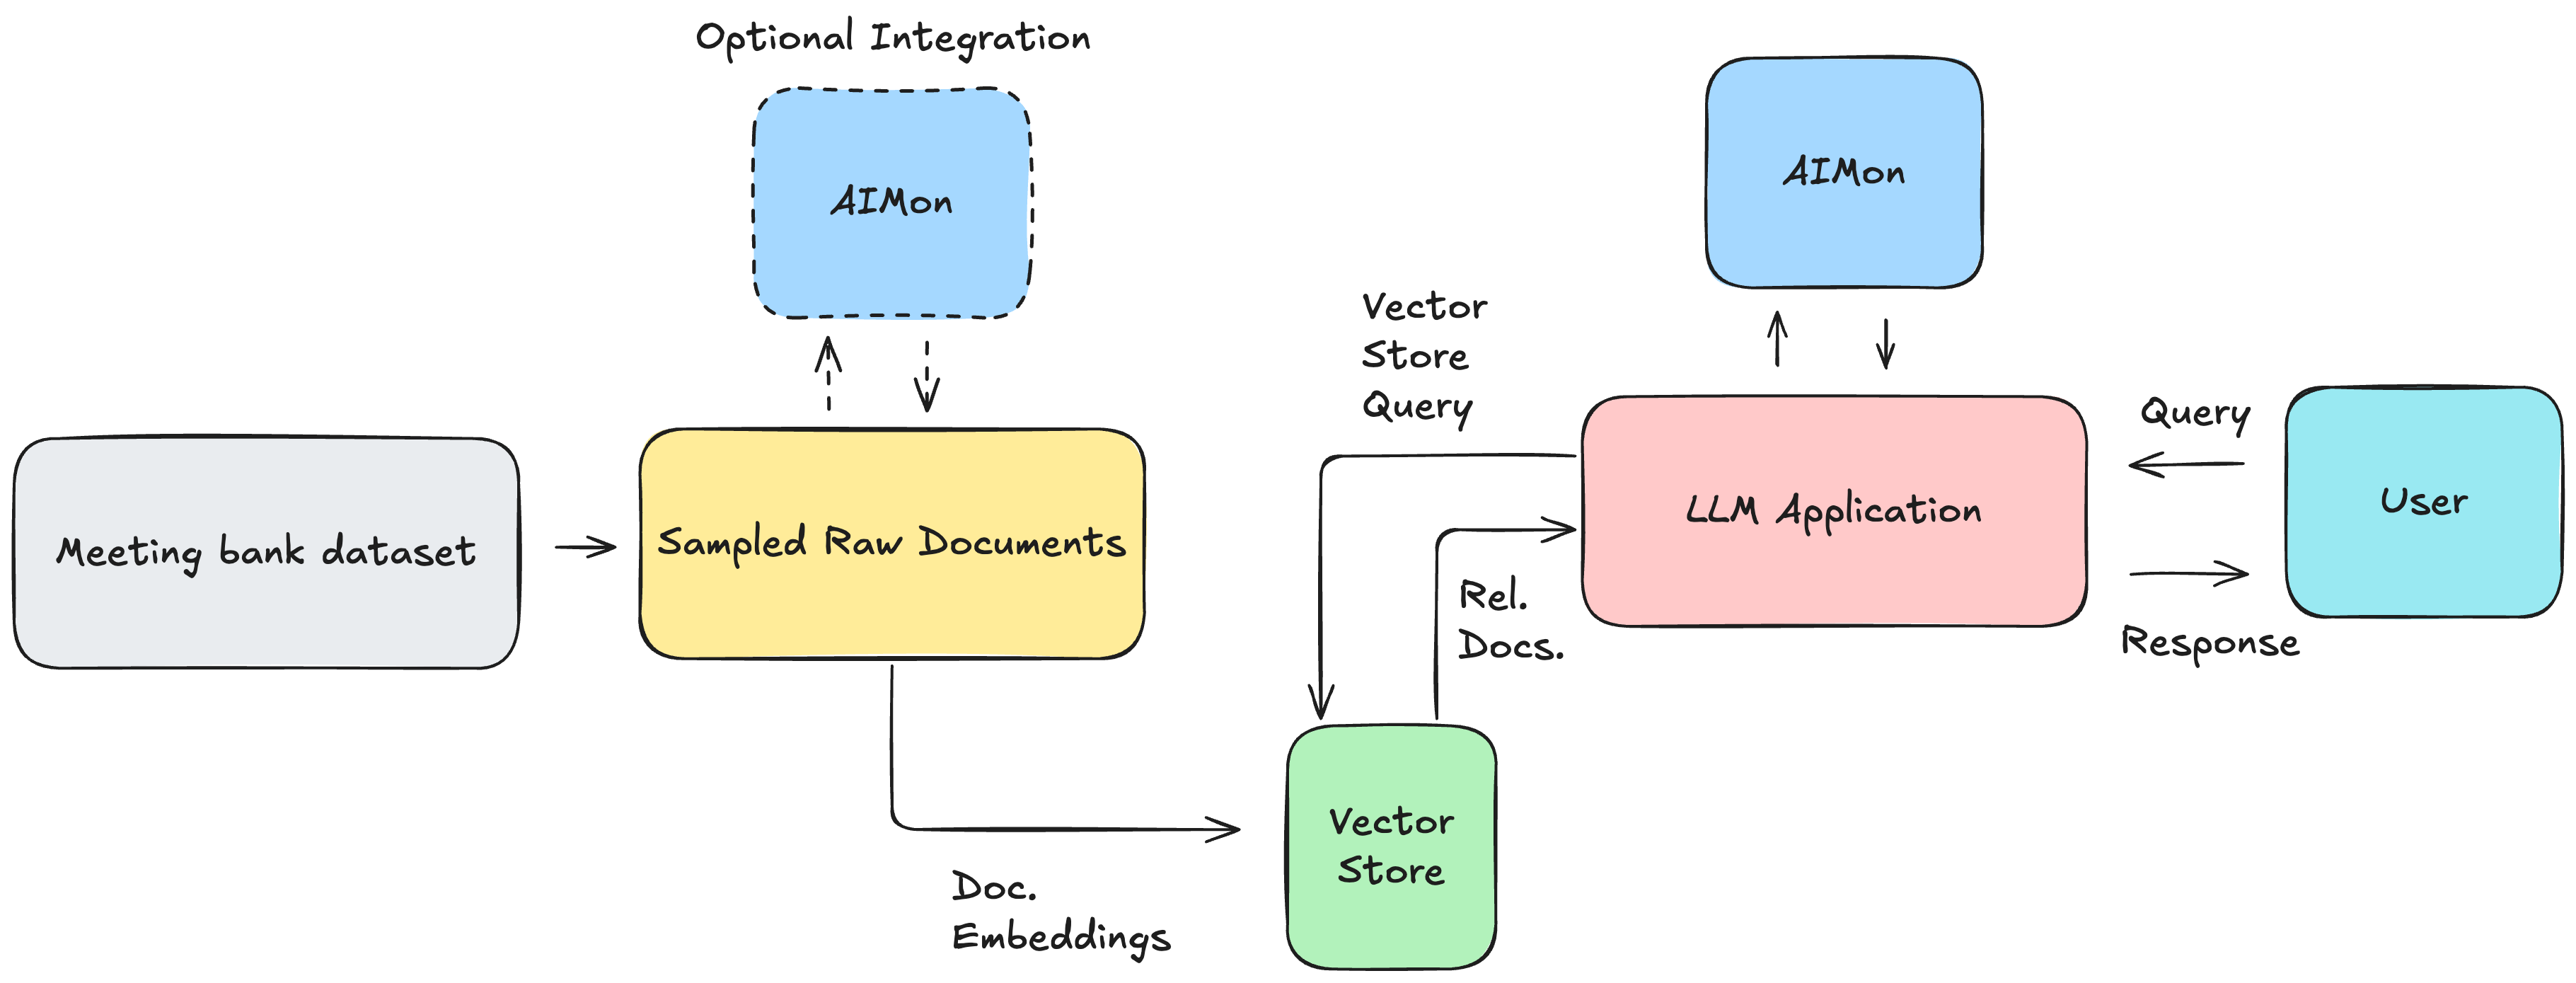

Below are some utility functions to pre-process and compute embeddings for documents.

In [ ]:
import json
import requests
import pandas as pd
from llama_index.core import Document


## Function to preprocess text.
def preprocess_text(text):
    text = " ".join(text.split())
    return text


## Function to process all URLs and create LlamaIndex Documents.
def extract_and_create_documents(transcripts):

    documents = []

    for indx, t in enumerate(transcripts):
        try:
            clean_text = preprocess_text(t)
            doc = Document(text=clean_text, metadata={"index": indx})
            documents.append(doc)
        except Exception as e:
            print(f"Failed to process transcript number {indx}: {str(e)}")

    return documents


documents = extract_and_create_documents(train_split["transcript"])

Setup an Open AI based embedding computation model.

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbedding

embedding_model = OpenAIEmbedding(
    model="text-embedding-3-small", embed_batch_size=100, max_retries=3
)

In this cell, we compute the embeddings for the `documents` and index them into the MilvusVectorStore.

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.milvus import MilvusVectorStore

vector_store = MilvusVectorStore(
    uri="./aimon_embeddings.db",
    collection_name="meetingbanks",
    dim=1536,
    overwrite=True,
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex.from_documents(
    documents=documents, storage_context=storage_context
)

2025-04-10 20:40:51,855 [DEBUG][_create_connection]: Created new connection using: 24fee991f1f64fadb3461a7d99fcd4dd (async_milvus_client.py:600)


Execution time: 38.74 seconds


Now that the VectorDB index has been setup, we will leverage it to answer user queries. In the cells below, we will create a retriever, setup the LLM and build a LLamaIndex Query Engine that interfaces with the retriever and the LLM to answer a user's questions.

In [ ]:
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

retriever = VectorIndexRetriever(index=index, similarity_top_k=5)

# The system prompt that will be used for the LLM
system_prompt = """
                Please be professional and polite.
                Answer the user's question in a single line.
                """

In [ ]:
## OpenAI's LLM, we will use GPT-4o-mini here since it is a fast and cheap LLM
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4o-mini", temperature=0.1, system_prompt=system_prompt)

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine

query_engine = RetrieverQueryEngine.from_args(retriever, llm)

At this point, the query engine, retriever and LLM has been setup. Next, we setup AIMon to help us measure quality scores. We use the same `@detect` decorator that was created in the previous cells above. The only additional code in `ask_and_validate` here is to help AIMon interface with LLamaIndex's retrieved document "nodes".  

In [ ]:
import logging


@detect
def ask_and_validate(user_query, user_instructions, query_engine=query_engine):

    response = query_engine.query(user_query)

    ## Nested function to retrieve context and relevance scores from the LLM response.
    def get_source_docs(chat_response):
        contexts = []
        relevance_scores = []
        if hasattr(chat_response, "source_nodes"):
            for node in chat_response.source_nodes:
                if (
                    hasattr(node, "node")
                    and hasattr(node.node, "text")
                    and hasattr(node, "score")
                    and node.score is not None
                ):
                    contexts.append(node.node.text)
                    relevance_scores.append(node.score)
                elif (
                    hasattr(node, "text")
                    and hasattr(node, "score")
                    and node.score is not None
                ):
                    contexts.append(node.text)
                    relevance_scores.append(node.score)
                else:
                    logging.info("Node does not have required attributes.")
        else:
            logging.info("No source_nodes attribute found in the chat response.")
        return contexts, relevance_scores

    context, relevance_scores = get_source_docs(response)
    return context, user_query, user_instructions, response.response, task_definition

In [ ]:
# Quick check to ensure everything is working with the vector DB
ask_and_validate("Councilman Lopez", instructions_to_evaluate)

(["I know in in New Mexico on some of the reservations, there are people actually doing filming, too, now of some of the elders to make sure that that history is documented and passed on, because it isn't translated in many of the history books you get in your public education system. So I again, just am happy to support this and again commend Councilman Lopez for his efforts in our Indian commission and the work that you all have done with our entire entire community. Thank you, Mr. President. Thank you, Councilwoman. Councilman Lopez, I see you back up. Yeah. You know, I wanted to really emphasize the 10th, Monday, the 10th and proclamation that will be here in the quarters we'd love for. And I wanted to make sure the community because we do have community folks, I want to make sure that we come back on the 10th because we would like to give not only the proclamation, but a copy of the bill over. Right. And and ceremoniously and also just for the community. I know this Saturday I did

Lets run through all the queries through the LlamaIndex query engine in the `queries_df` and compute the overall quality score using AIMon.

**NOTE: This will take about 2 mins**

In [ ]:
import time

quality_scores_vdb = []
avg_retrieval_rel_scores_vdb = []
responses_adb = {}
ast = time.time()
for user_query in queries_df["Query"].to_list():
    _, _, _, llm_res, _, aimon_response = ask_and_validate(
        user_query, instructions_to_evaluate
    )
    # These show the average retrieval relevance scores per query. Compare this to the previous brute force method.
    retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0][
        "relevance_scores"
    ]
    avg_retrieval_rel_score_per_query = (
        statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
    )
    avg_retrieval_rel_scores_vdb.append(avg_retrieval_rel_score_per_query)
    print(
        "Avg. Retrieval relevance score across chunks: {} for query: {}".format(
            avg_retrieval_rel_score_per_query, user_query
        )
    )
    quality_scores_vdb.append(compute_quality_score(aimon_response))
    responses_adb[user_query] = llm_res
print("Time elapsed: {} seconds".format(time.time() - ast))

Avg. Retrieval relevance score across chunks: 19.932596854170086 for query: What was the key decision in the meeting?
Avg. Retrieval relevance score across chunks: 19.332469976717874 for query: What are the next steps for the team?
Avg. Retrieval relevance score across chunks: 13.695729082342893 for query: Summarize the meeting in 10 words.
Avg. Retrieval relevance score across chunks: 20.276701279455835 for query: What were the main points of discussion?
Avg. Retrieval relevance score across chunks: 19.642715112968148 for query: What decision was made regarding the project?
Avg. Retrieval relevance score across chunks: 17.880496811886246 for query: What were the outcomes of the meeting?
Avg. Retrieval relevance score across chunks: 23.53911458826815 for query: What was discussed in the meeting?
Avg. Retrieval relevance score across chunks: 17.665638657211105 for query: What examples were discussed for project inspiration?
Avg. Retrieval relevance score across chunks: 18.13388221868742

In [ ]:
# This is the average quality score.
avg_quality_score_vdb = statistics.mean(quality_scores_vdb)
print("Average Quality score for vector DB approach: {}".format(avg_quality_score_vdb))

Average Quality score for vector DB approach: 67.1800392915634


In [ ]:
# This is the average retrieval relevance score.
avg_retrieval_rel_score_vdb = statistics.mean(avg_retrieval_rel_scores_vdb)
print(
    "Average retrieval relevance score for vector DB approach: {}".format(
        avg_retrieval_rel_score_vdb
    )
)

Average retrieval relevance score for vector DB approach: 19.296728194100236


## 🎉 Quality Score improved!

Notice that the overall quality score across all queries improved after using a RAG based QA system.




# 3. Add Re-ranking to your retrieval

Now, we will add in AIMon's [domain adaptable re-ranker](https://docs.aimon.ai/retrieval#domain-adaptable-re-ranking) using AIMon's LlamaIndex [postprocessor re-rank integration](https://docs.llamaindex.ai/en/latest/examples/node_postprocessor/AIMonRerank/).

As shown in the figure below, reranking helps bubble up the most relevant documents to the top by using a more advanced Query-Document matching function. The unique feature of AIMon's re-ranker is the ability to customize it per domain. Similar to how you would prompt engineer an LLM, you can customize reranking performance per domain using the `task_definition` field. This state-of-the-art reranker runs at ultra low sub second latency (for a ~2k context) and its performance ranks in the top 5 of the MTEB reranking leaderboard.

<img src="https://raw.githubusercontent.com/devvratbhardwaj/images/refs/heads/main/AIMon_Reranker.svg" alt="Diagram depicting working of AIMon reranker"/>

In [ ]:
# Setup AIMon's reranker

from llama_index.postprocessor.aimon_rerank import AIMonRerank

# This is a simple task_definition, you can polish and customize it for your use cases as needed
task_definition = """
Your task is to match documents for a specific query.
The documents are transcripts of meetings of city councils of 6 major U.S. cities.
"""

aimon_rerank = AIMonRerank(
    top_n=2,
    api_key=userdata.get("AIMON_API_KEY"),
    task_definition=task_definition,
)

In [ ]:
# Setup a new query engine but now with a reranker added as a post processor after retrieval

query_engine_with_reranking = RetrieverQueryEngine.from_args(
    retriever, llm, node_postprocessors=[aimon_rerank]
)

Let's run through the queries again and recompute the overall quality score to see if there is an improvement.

✨ **AIMon's re-ranking should not add additional latency overhead since it actually reduces the amount of context documents that need to be sent to the LLM for generating a response making the operation efficient in terms of network I/O and LLM token processing cost (money and time).**

**NOTE: This step will take 2 mins**

In [ ]:
import time

qual_scores_rr = []
avg_retrieval_rel_scores_rr = []
responses_adb_rr = {}
ast_rr = time.time()
for user_query in queries_df["Query"].to_list():
    _, _, _, llm_res, _, aimon_response = ask_and_validate(
        user_query, instructions_to_evaluate, query_engine=query_engine_with_reranking
    )
    # These show the average retrieval relevance scores per query. Compare this to the previous method without the re-ranker
    retrieval_rel_scores = aimon_response.detect_response.retrieval_relevance[0][
        "relevance_scores"
    ]
    avg_retrieval_rel_score_per_query = (
        statistics.mean(retrieval_rel_scores) if len(retrieval_rel_scores) > 0 else 0.0
    )
    avg_retrieval_rel_scores_rr.append(avg_retrieval_rel_score_per_query)
    print(
        "Avg. Retrieval relevance score across chunks: {} for query: {}".format(
            avg_retrieval_rel_score_per_query, user_query
        )
    )
    qual_scores_rr.append(compute_quality_score(aimon_response))
    responses_adb_rr[user_query] = llm_res
print("Time elapsed: {} seconds".format(time.time() - ast_rr))

Avg. Retrieval relevance score across chunks: 36.436465411440366 for query: What was the key decision in the meeting?
Avg. Retrieval relevance score across chunks: 38.804003013309085 for query: What are the next steps for the team?
Avg. Retrieval relevance score across chunks: 45.29209086832342 for query: Summarize the meeting in 10 words.
Avg. Retrieval relevance score across chunks: 36.979413900164815 for query: What were the main points of discussion?
Avg. Retrieval relevance score across chunks: 41.149971422535714 for query: What decision was made regarding the project?
Avg. Retrieval relevance score across chunks: 36.57368907582921 for query: What were the outcomes of the meeting?
Avg. Retrieval relevance score across chunks: 42.34540670899989 for query: What was discussed in the meeting?
Avg. Retrieval relevance score across chunks: 33.857591391574715 for query: What examples were discussed for project inspiration?
Avg. Retrieval relevance score across chunks: 38.419397677952816 

Notice the difference in average document relevance scores when using the reranker v/s when not using the reranker v/s using a naive, brute-force approach.

In [ ]:
# This is the average quality score.
avg_quality_score_rr = statistics.mean(qual_scores_rr)
print(
    "Average Quality score for AIMon Re-ranking approach: {}".format(
        avg_quality_score_rr
    )
)

Average Quality score for AIMon Re-ranking approach: 74.62174819211145


In [ ]:
# This is the average retrieval relevance score.
avg_retrieval_rel_score_rr = statistics.mean(avg_retrieval_rel_scores_rr)
print(
    "Average retrieval relevance score for AIMon Re-ranking approach: {}".format(
        avg_retrieval_rel_score_rr
    )
)

Average retrieval relevance score for AIMon Re-ranking approach: 39.794702307038214


## 🎉 Again, Quality Score improved!

Notice that the overall quality score across all queries improved after using AIMon's reranker.

In sum, as shown in the figure below, we demonstrated the following:

* Computing a quality score using a weighted combination of 3 different quality metrics: hallucination score, instruction adherence score and retrieval relevance score.
* Established a quality baseline using a brute force string matching approach to match documents to a query and pass that to an LLM.
* Improved the baseline quality using a Vector DB (here, we used Milvus)
* Further improved the quality score using AIMon's low-latency, domain adaptable re-ranker.
* We also showed how retrieval relevance improves significantly by adding in AIMon's re-ranker.

We encourage you to experiment with the different components shown in this notebook to further **increase the quality score**. One idea is to add your own definitions of quality using the `instructions` field in the instruction_adherence detector above. Another idea is to add another one of [AIMon's checker models](https://docs.aimon.ai/category/checker-models) as part of the quality metric calculation.

Happy experimenting! Join our [discord server](https://discord.gg/Cp6YZ9qTdm) for fun conversations on AI!

In [ ]:
import pandas as pd

df_scores = pd.DataFrame(
    {
        "Approach": ["Brute-Force", "VectorDB", "AIMon-Rerank"],
        "Quality Score": [
            avg_quality_score_bf,
            avg_quality_score_vdb,
            avg_quality_score_rr,
        ],
        "Retrieval Relevance Score": [
            avg_retrieval_rel_score_bf,
            avg_retrieval_rel_score_vdb,
            avg_retrieval_rel_score_rr,
        ],
    }
)

# % increase of quality scores relative to Brute-Force
df_scores["Increase in Quality Score (%)"] = (
    (df_scores["Quality Score"] - avg_quality_score_bf) / avg_quality_score_bf
) * 100
df_scores.loc[0, "Increase in Quality Score (%)"] = 0

# % increase of retrieval relative scores relative to Brute-Force
df_scores["Increase in Retrieval Relevance Score (%)"] = (
    (df_scores["Retrieval Relevance Score"] - avg_retrieval_rel_score_bf)
    / avg_retrieval_rel_score_bf
) * 100
df_scores.loc[0, "Increase in Retrieval Relevance Score (%)"] = 0

df_scores

,Approach,Quality Score,Retrieval Relevance Score,Increase in Quality Score (%),Increase in Retrieval Relevance Score (%)
0,Brute-Force,51.750446,14.317723,0.000000,0.000000
1,VectorDB,67.180039,19.296728,29.815382,34.775115
2,AIMon-Rerank,74.621748,39.794702,44.195372,177.940153


The above table summarizes our results. Your actual numbers will vary depending on various factors such as variations in quality of LLM responses, performance of the nearest neighbor search in the VectorDB etc.

In conclusion, as shown by the figure below, we evaluated quality score, RAG relevance and instruction following capabilities of your LLM application. We used AIMon's re-ranker to improve the overall quality of the application and the average relevance of documents retrieved from your RAG.